# TEMPO Development Notebook

**T**rajectory **E**nrichment via **M**atrix **P**rofile **O**utcomes

This notebook tracks the development of each TEMPO module as it gets implemented. Run any section to see its current state.

| Module | Status |
|--------|--------|
| `simulate` | ✅ Implemented |
| `preprocess` | ✅ Implemented |
| `harbinger` | ✅ Implemented |
| `stats` | 🔲 Stub |
| `viz` | 🔲 Stub |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from tempo import simulate

sns.set_theme(style='whitegrid', palette='muted')
case_color = '#e05c5c'
ctrl_color = '#5c8ae0'
print('tempo imported OK')

tempo imported OK


---
## 1  `simulate` — Longitudinal Compositional Data

Generates 16S-style compositional trajectories. Case subjects have an embedded motif (elevated abundance in `motif_features` during `motif_window`). All rows sum to 1 per subject per timepoint.

In [2]:
df = simulate.simulate_longitudinal(
    n_subjects=40,
    n_timepoints=12,
    n_features=20,
    n_cases=15,
    motif_features=[0, 1, 2],
    motif_window=(4, 8),
    motif_strength=2.5,
    noise_sd=0.2,
    zero_inflation=0.1,
    seed=42,
)

truth = simulate.get_ground_truth(df)
window = truth['motif_window']
features = sorted(df['feature'].unique())
timepoints = sorted(df['timepoint'].unique())

print(f'Shape: {df.shape}')
print(f'Subjects: {df.subject_id.nunique()} '
      f'({df[df.outcome==1].subject_id.nunique()} cases, '
      f'{df[df.outcome==0].subject_id.nunique()} controls)')
print(f'Ground truth motif features: {truth["motif_features"]}')
print(f'Ground truth motif window:   timepoints {window[0]}–{window[1]}')
df.head(6)

Shape: (9600, 5)
Subjects: 40 (15 cases, 25 controls)
Ground truth motif features: ['feature_000', 'feature_001', 'feature_002']
Ground truth motif window:   timepoints 4–8


,subject_id,timepoint,feature,value,outcome
0,case_000,0,feature_000,0.060620,1
1,case_000,0,feature_001,0.082167,1
2,case_000,0,feature_002,0.053242,1
3,case_000,0,feature_003,0.047673,1
4,case_000,0,feature_004,0.000000,1
5,case_000,0,feature_005,0.050812,1


In [3]:
# Compositional constraint check
sums = df.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f'Value sums — min: {sums.min():.6f}, max: {sums.max():.6f}')
print(f'Zero rate: {(df.value == 0).mean():.1%}')

Value sums — min: 1.000000, max: 1.000000
Zero rate: 10.1%


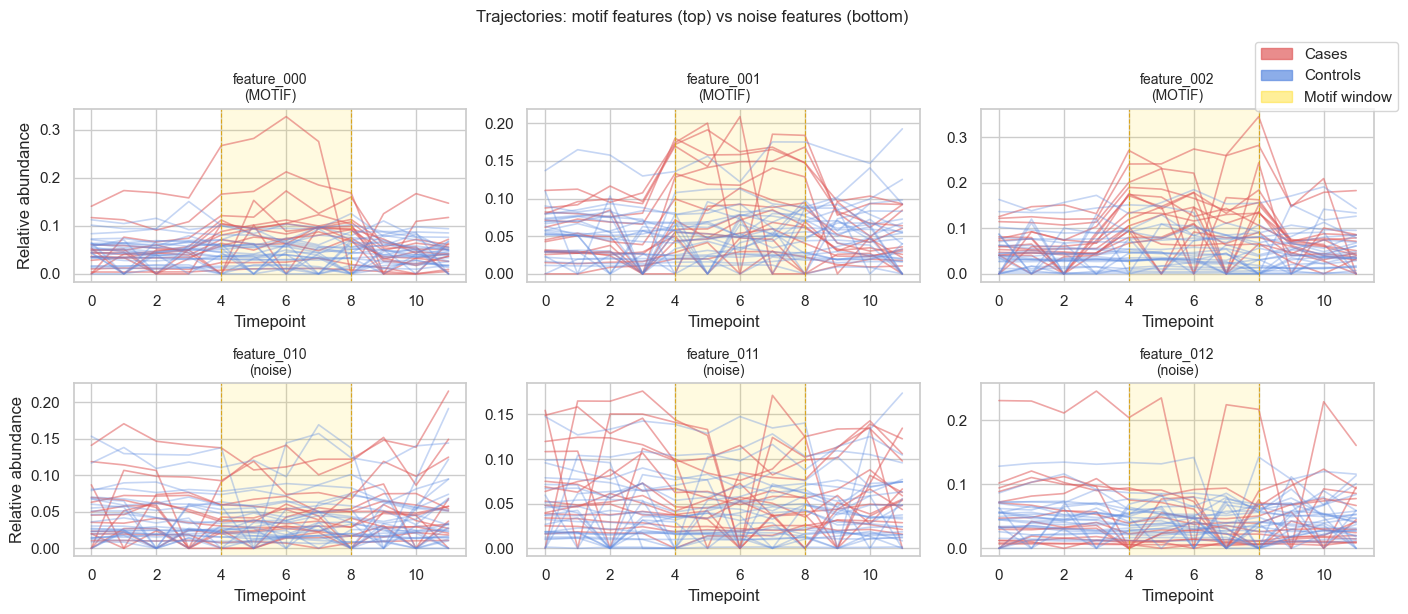

In [4]:
# Individual trajectories: motif features (top) vs noise features (bottom)
motif_feats = truth['motif_features']
noise_feats = ['feature_010', 'feature_011', 'feature_012']

fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharey=False)

for row_idx, feat_group in enumerate([motif_feats, noise_feats]):
    for col_idx, feat in enumerate(feat_group):
        ax = axes[row_idx, col_idx]
        feat_df = df[df['feature'] == feat]

        for subj, grp in feat_df.groupby('subject_id'):
            outcome = grp['outcome'].iloc[0]
            color = case_color if outcome == 1 else ctrl_color
            alpha = 0.55 if outcome == 1 else 0.35
            ax.plot(grp['timepoint'], grp['value'], color=color, alpha=alpha, lw=1.2)

        ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
        ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
        ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
        label = f'{feat}\n(MOTIF)' if row_idx == 0 else f'{feat}\n(noise)'
        ax.set_title(label, fontsize=10)
        ax.set_xlabel('Timepoint')
        if col_idx == 0:
            ax.set_ylabel('Relative abundance')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
window_patch = mpatches.Patch(color='gold', label='Motif window', alpha=0.4)
fig.legend(handles=[case_patch, ctrl_patch, window_patch],
           loc='upper right', bbox_to_anchor=(1.01, 0.98))
fig.suptitle('Trajectories: motif features (top) vs noise features (bottom)',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

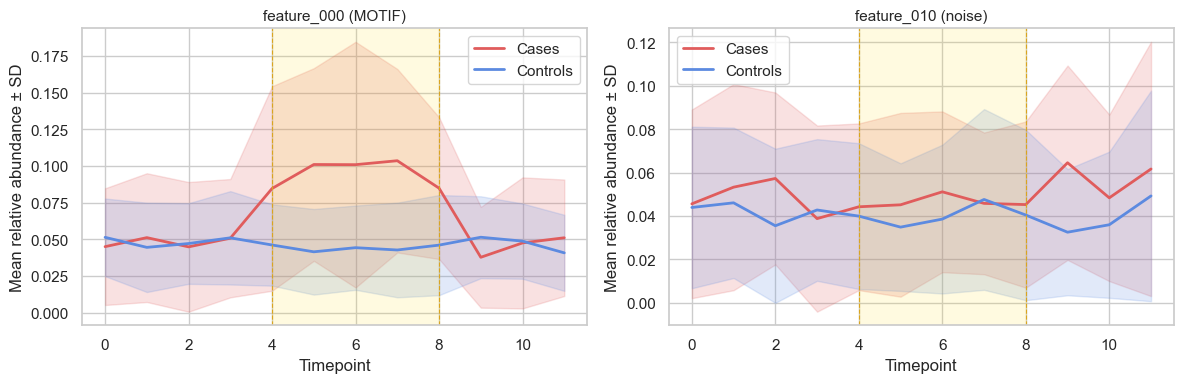

In [5]:
# Group mean ± SD for one motif feature vs one noise feature
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_010'],
    ['feature_000 (MOTIF)', 'feature_010 (noise)']
):
    feat_df = df[df['feature'] == feat]
    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds,
                        color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Mean relative abundance ± SD')
    ax.legend()

plt.tight_layout()
plt.show()

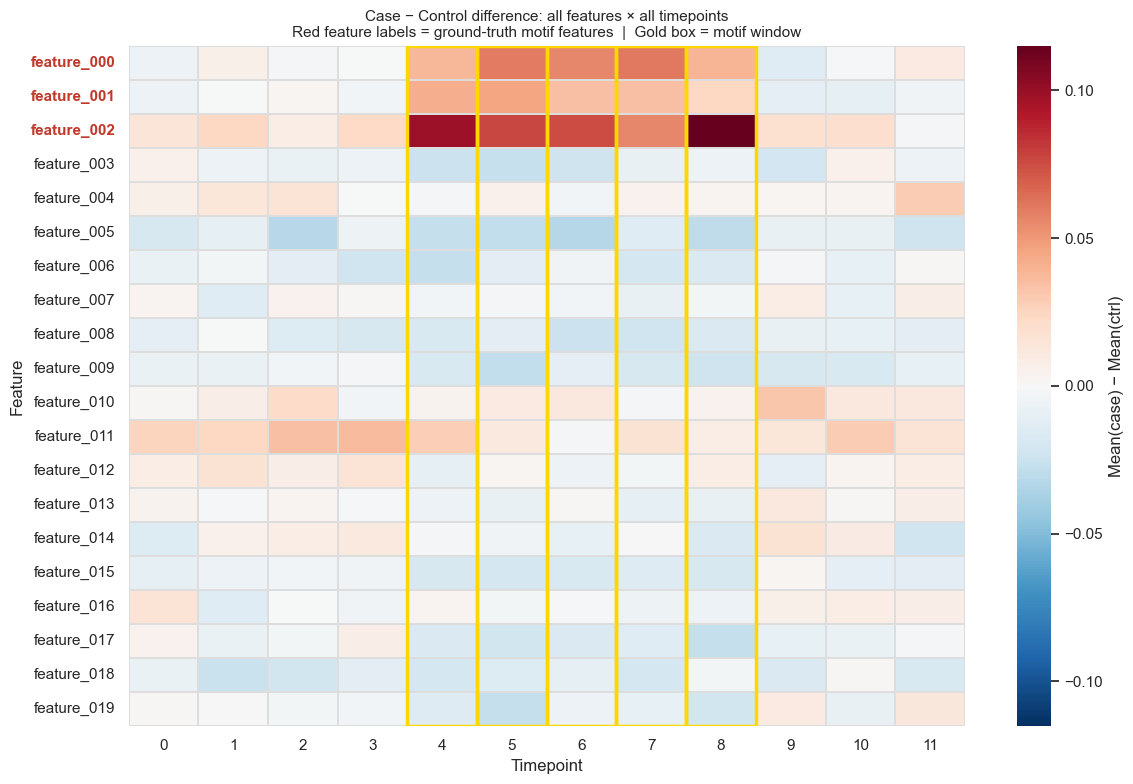

In [6]:
# All-features difference heatmap — see every feature at once.
# Colour = mean(case) − mean(ctrl) at each (feature, timepoint).
# Red feature labels = ground-truth motif features.
# Gold box = motif window.

case_mean = (
    df[df['outcome'] == 1]
    .groupby(['feature', 'timepoint'])['value'].mean()
    .unstack('timepoint').reindex(features)[timepoints]
)
ctrl_mean = (
    df[df['outcome'] == 0]
    .groupby(['feature', 'timepoint'])['value'].mean()
    .unstack('timepoint').reindex(features)[timepoints]
)
diff = case_mean - ctrl_mean

fig, ax = plt.subplots(figsize=(12, 8))
vmax = np.abs(diff.values).max()
sns.heatmap(
    diff, ax=ax,
    cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
    linewidths=0.3, linecolor='#dddddd',
    cbar_kws={'label': 'Mean(case) − Mean(ctrl)'},
)

# Gold border around motif window columns
for tp in range(window[0], window[1] + 1):
    col_idx = timepoints.index(tp)
    ax.add_patch(plt.Rectangle(
        (col_idx, 0), 1, len(features),
        fill=False, edgecolor='gold', lw=2.5, zorder=5
    ))

# Red labels for known motif features
for lbl in ax.get_yticklabels():
    if lbl.get_text() in truth['motif_features']:
        lbl.set_color('#c0392b')
        lbl.set_fontweight('bold')

ax.set_title(
    'Case − Control difference: all features × all timepoints\n'
    'Red feature labels = ground-truth motif features  |  Gold box = motif window',
    fontsize=11
)
ax.set_xlabel('Timepoint')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

---
## 2  `simulate` — Continuous Data (step / ramp / pulse motifs)

Non-compositional data (flow cytometry, gene expression). Three motif shapes.

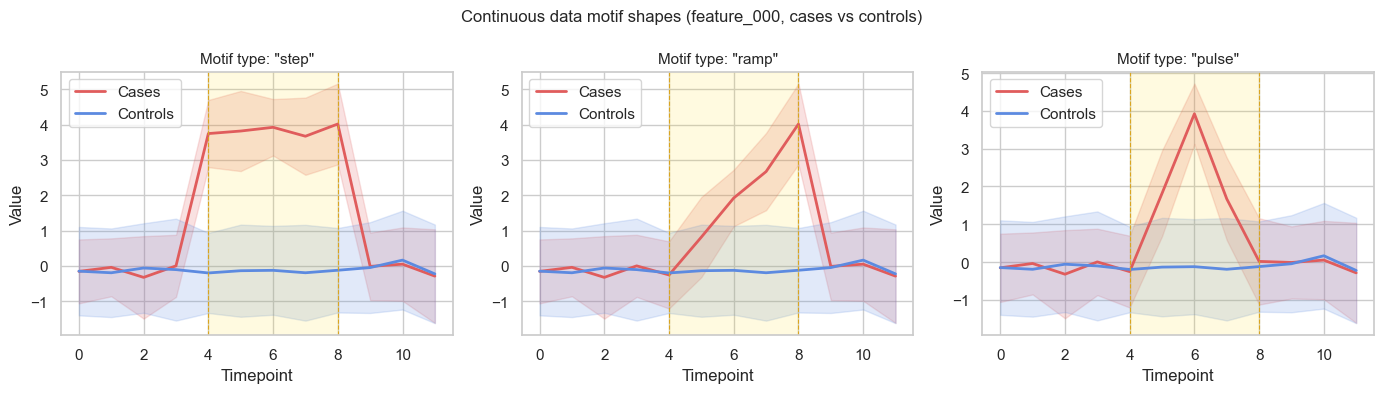

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

for ax, motif_type in zip(axes, ['step', 'ramp', 'pulse']):
    df_c = simulate.simulate_continuous(
        n_subjects=30, n_timepoints=12, n_features=5, n_cases=10,
        motif_features=[0], motif_window=(4, 8),
        motif_type=motif_type, motif_strength=4.0, noise_sd=0.5, seed=0
    )
    feat_df = df_c[df_c['feature'] == 'feature_000']

    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)

    ax.axvspan(4, 8, alpha=0.12, color='gold')
    ax.axvline(4, color='goldenrod', lw=0.8, ls='--')
    ax.axvline(8, color='goldenrod', lw=0.8, ls='--')
    ax.set_title(f'Motif type: "{motif_type}"', fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Value')
    ax.legend()

fig.suptitle('Continuous data motif shapes (feature_000, cases vs controls)', fontsize=12)
plt.tight_layout()
plt.show()

---
## 3  `simulate` — Outcome Types

The simulator supports binary, continuous, and survival outcomes.

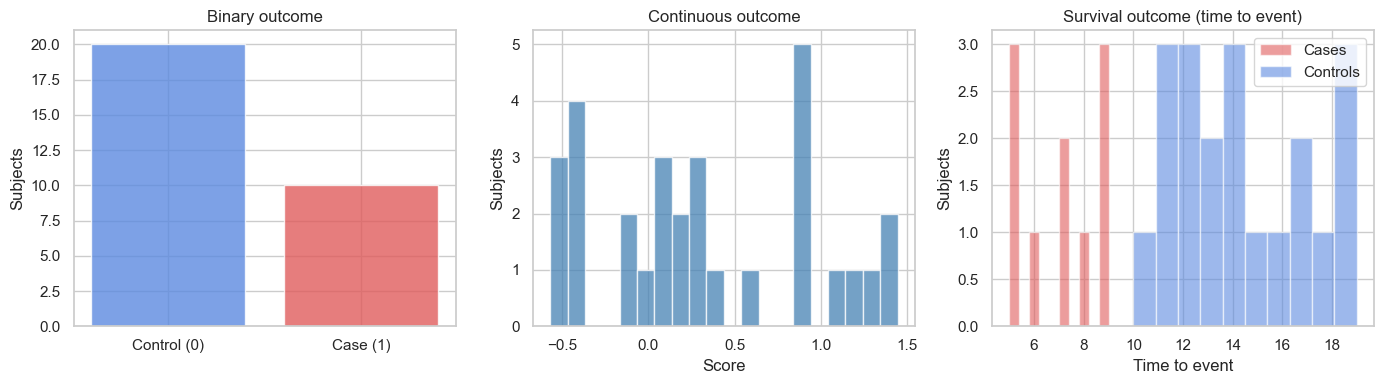

In [8]:
df_binary = simulate.simulate_longitudinal(outcome_type='binary', seed=0)
df_continuous = simulate.simulate_longitudinal(outcome_type='continuous', seed=0)
df_survival = simulate.simulate_longitudinal(outcome_type='survival', seed=0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

counts = df_binary.drop_duplicates('subject_id')['outcome'].value_counts()
axes[0].bar(['Control (0)', 'Case (1)'], [counts.get(0, 0), counts.get(1, 0)],
            color=[ctrl_color, case_color], alpha=0.8)
axes[0].set_title('Binary outcome')
axes[0].set_ylabel('Subjects')

axes[1].hist(df_continuous.drop_duplicates('subject_id')['outcome'],
             bins=20, color='steelblue', alpha=0.75)
axes[1].set_title('Continuous outcome')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Subjects')

subjects_s = df_survival.drop_duplicates('subject_id')
for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
    grp = subjects_s[subjects_s['outcome'] == outcome]['time_to_event']
    axes[2].hist(grp, bins=10, alpha=0.6, label=label, color=color)
axes[2].set_title('Survival outcome (time to event)')
axes[2].set_xlabel('Time to event')
axes[2].set_ylabel('Subjects')
axes[2].legend()

plt.tight_layout()
plt.show()

---
## 4  `simulate` — evaluation_report

Compares detected features/window against ground truth (used to score harbinger output).

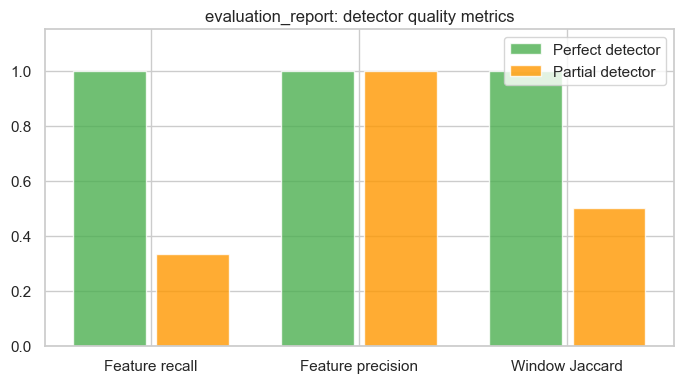

Perfect: {'feature_recall': 1.0, 'feature_precision': 1.0, 'window_jaccard': 1.0, 'true_features': ['feature_001', 'feature_000', 'feature_002'], 'detected_features': ['feature_001', 'feature_000', 'feature_002'], 'true_window': (3, 7), 'detected_window': (3, 7)}
Partial: {'feature_recall': 0.333, 'feature_precision': 1.0, 'window_jaccard': 0.5, 'true_features': ['feature_001', 'feature_000', 'feature_002'], 'detected_features': ['feature_000'], 'true_window': (3, 7), 'detected_window': (5, 8)}


In [9]:
df_eval = simulate.simulate_longitudinal(
    motif_features=[0, 1, 2], motif_window=(3, 7), seed=0
)

perfect = simulate.evaluation_report(
    detected_features=['feature_000', 'feature_001', 'feature_002'],
    detected_window=(3, 7), df=df_eval
)
partial = simulate.evaluation_report(
    detected_features=['feature_000'],
    detected_window=(5, 8), df=df_eval
)

metrics = ['feature_recall', 'feature_precision', 'window_jaccard']
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(metrics))
ax.bar(x - 0.2, [perfect[m] for m in metrics], 0.35,
       label='Perfect detector', color='#4caf50', alpha=0.8)
ax.bar(x + 0.2, [partial[m] for m in metrics], 0.35,
       label='Partial detector', color='#ff9800', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Feature recall', 'Feature precision', 'Window Jaccard'])
ax.set_ylim(0, 1.15)
ax.set_title('evaluation_report: detector quality metrics')
ax.legend()
plt.tight_layout()
plt.show()

print('Perfect:', perfect)
print('Partial:', partial)

---
## 5  `preprocess` — ✅ Implemented

In [10]:
from tempo.preprocess import preprocess, clr_transform, bray_curtis_trajectory

df_raw = simulate.simulate_longitudinal(seed=42)

# CLR transform
df_clr = clr_transform(df_raw)
print('CLR output shape:', df_clr.shape)
print(f'CLR values sum to zero per sample: '
      f'{df_clr.groupby(["subject_id","timepoint"])["value"].sum().abs().max():.2e}')

# Bray-Curtis trajectory distances
df_bc = bray_curtis_trajectory(df_raw)
print(f'\nBray-Curtis output shape: {df_bc.shape}')
print(f'Distance range: [{df_bc["distance"].min():.4f}, {df_bc["distance"].max():.4f}]')
df_bc.head()

CLR output shape: (6000, 5)
CLR values sum to zero per sample: 1.38e-14

Bray-Curtis output shape: (270, 4)
Distance range: [0.0099, 0.3997]


,subject_id,timepoint,distance,outcome
0,case_000,1,0.107156,1
1,case_000,2,0.159348,1
2,case_000,3,0.122643,1
3,case_000,4,0.125064,1
4,case_000,5,0.280121,1


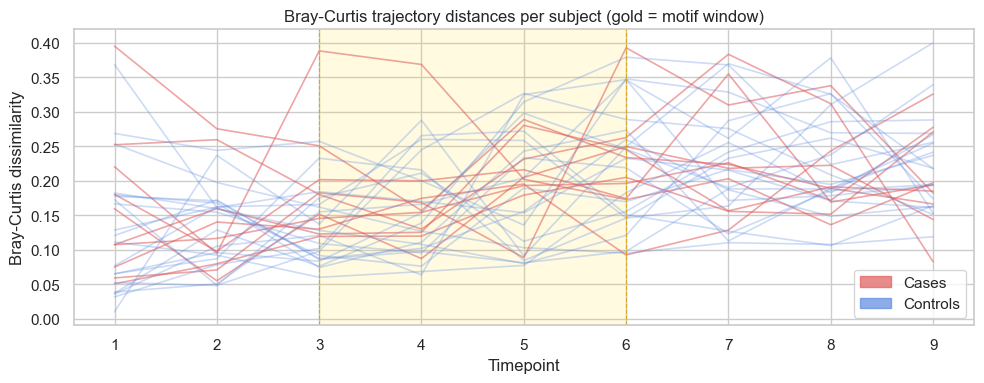

In [11]:
# Visualise Bray-Curtis distance trajectories: cases vs controls
fig, ax = plt.subplots(figsize=(10, 4))
truth_raw = simulate.get_ground_truth(df_raw)
win = truth_raw['motif_window']

for subj, grp in df_bc.groupby('subject_id'):
    outcome = grp['outcome'].iloc[0]
    color = case_color if outcome == 1 else ctrl_color
    alpha = 0.55 if outcome == 1 else 0.3
    ax.plot(grp['timepoint'], grp['distance'], color=color, alpha=alpha, lw=1.2)

ax.axvspan(win[0], win[1], alpha=0.12, color='gold')
ax.axvline(win[0], color='goldenrod', lw=0.8, ls='--')
ax.axvline(win[1], color='goldenrod', lw=0.8, ls='--')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
ax.legend(handles=[case_patch, ctrl_patch])
ax.set_xlabel('Timepoint')
ax.set_ylabel('Bray-Curtis dissimilarity')
ax.set_title('Bray-Curtis trajectory distances per subject (gold = motif window)')
plt.tight_layout()
plt.show()

---
## 6  `harbinger` — ✅ Implemented

In [12]:
from tempo.harbinger import harbinger

df_h = simulate.simulate_longitudinal(
    n_subjects=40, n_cases=15,
    motif_features=[0, 1, 2], motif_window=(4, 8),
    motif_strength=2.5, seed=42
)

results = harbinger(df_h, window_size=3, top_k=10)
print('Harbinger results:')
print(results)

truth_h = simulate.get_ground_truth(df_h)
top_features = results['feature'].head(3).tolist()
top_window = results['motif_window'].iloc[0]
report = simulate.evaluation_report(top_features, top_window, df_h)
print('\nEvaluation report:', report)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Harbinger results:
       feature motif_window  enrichment_score  p_value  matrix_profile_min
0  feature_001       (4, 6)          0.058414    0.000            1.661326
1  feature_000       (4, 6)          0.055684    0.001            1.817606
2  feature_011       (0, 2)          0.021774    0.071            1.831606
3  feature_018       (6, 8)          0.016765    0.069            1.627770
4  feature_015       (2, 4)          0.008451    0.210            1.566024
5  feature_002       (7, 9)          0.007823    0.238            1.632761
6  feature_019       (4, 6)          0.006146    0.206            1.617920
7  feature_006       (2, 4)          0.001817    0.393            1.949542
8  feature_007       (3, 5)         -0.000474    0.499            1.547175
9  feature_012       (5, 7)         -0.004110    0.658            1.718764

Evaluation report: {'feature_recall': 0.667, 'feature_precision': 0.667, 'window_jaccard': 0.6, 'true_features': ['feature_001', 'feature_000', 'feature_00

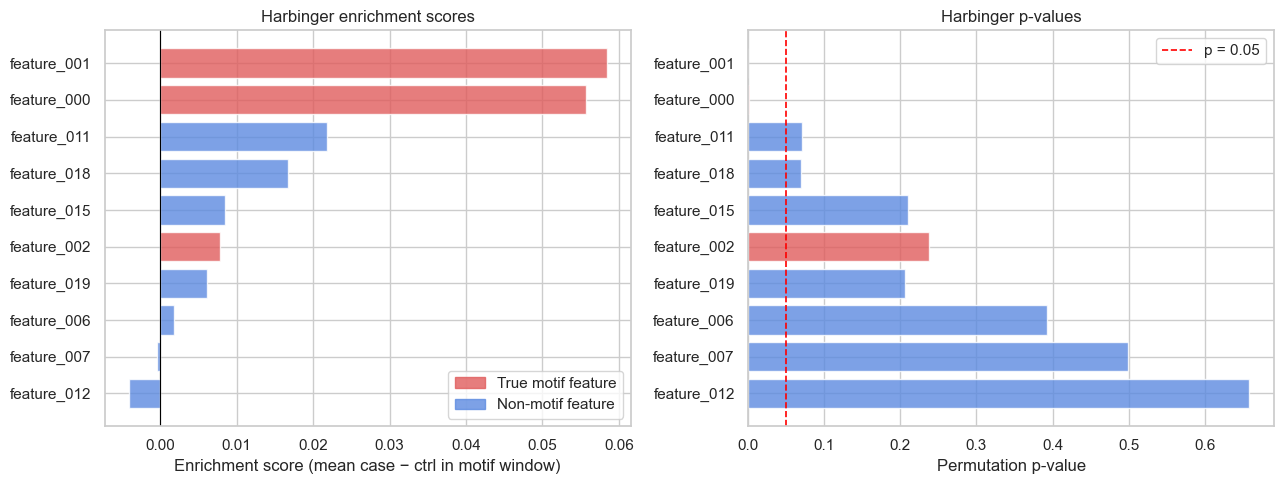

In [13]:
# Visualise harbinger results: enrichment scores and p-values
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

motif_feats_h = truth_h['motif_features']
colors_bar = [case_color if f in motif_feats_h else ctrl_color
              for f in results['feature']]

# Enrichment scores
axes[0].barh(results['feature'][::-1], results['enrichment_score'][::-1],
             color=colors_bar[::-1], alpha=0.8)
axes[0].axvline(0, color='black', lw=0.8)
axes[0].set_xlabel('Enrichment score (mean case − ctrl in motif window)')
axes[0].set_title('Harbinger enrichment scores')

case_patch = mpatches.Patch(color=case_color, label='True motif feature', alpha=0.8)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Non-motif feature', alpha=0.8)
axes[0].legend(handles=[case_patch, ctrl_patch], loc='lower right')

# p-values with significance line
axes[1].barh(results['feature'][::-1], results['p_value'][::-1],
             color=colors_bar[::-1], alpha=0.8)
axes[1].axvline(0.05, color='red', lw=1.2, ls='--', label='p = 0.05')
axes[1].set_xlabel('Permutation p-value')
axes[1].set_title('Harbinger p-values')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 7  `stats` — 🔲 Stub

In [14]:
from tempo.stats import permutation_test, enrichment_score, survival_test

df_s = simulate.simulate_longitudinal(motif_features=[0], motif_window=(4, 8), seed=42)

for feat in ['feature_000', 'feature_010']:
    try:
        perm = permutation_test(df_s, feature=feat, motif_window=(4, 8), n_permutations=999)
        print(f'{feat}: p = {perm["p_value"]:.4f}')
    except NotImplementedError as e:
        print(f'[not yet] {e}')

df_surv = simulate.simulate_longitudinal(outcome_type='survival',
                                         motif_features=[0], motif_window=(4, 8), seed=42)
try:
    surv = survival_test(df_surv, feature='feature_000', motif_window=(4, 8))
    print(f'Survival test: p = {surv["p_value"]:.4f}')
except NotImplementedError as e:
    print(f'[not yet] {e}')

[not yet] permutation_test() is not yet implemented.
[not yet] permutation_test() is not yet implemented.
[not yet] survival_test() is not yet implemented. Planned: log-rank test via scipy.stats, Cox via lifelines.


---
## 8  `viz` — 🔲 Stub

In [15]:
from tempo.viz import plot_motifs, plot_enrichment

df_v = simulate.simulate_longitudinal(
    motif_features=[0, 1, 2], motif_window=(4, 8), motif_strength=2.5, seed=42
)

try:
    fig = plot_motifs(df_v, features=['feature_000', 'feature_001', 'feature_010'],
                      motif_window=(4, 8))
    plt.show()
except NotImplementedError as e:
    print(f'[not yet] {e}')

try:
    fig = plot_enrichment(results, top_k=10)
    plt.show()
except NotImplementedError as e:
    print(f'[not yet] {e}')

[not yet] plot_motifs() is not yet implemented. Planned: matplotlib/seaborn trajectory overlay with motif window shading.
[not yet] plot_enrichment() is not yet implemented. Planned: seaborn heatmap with significance annotations.
